In [32]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,plot_confusion_matrix,roc_curve, confusion_matrix,classification_report,f1_score,precision_score,jaccard_score,accuracy_score,recall_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
def plot_performance(true,pred,threshold):
    fig,ax = plt.subplots(2,2,figsize = (10,10),constrained_layout = True)
    ax.flat[2].set_visible(False)
    ax.flat[3].set_visible(False)
    print(classification_report(y_test,pred))
    sns.heatmap(confusion_matrix(y_test,pred),ax = ax[0,0],cmap = "Blues",annot = True,fmt = ".2f").set_title("confusion matrix")
    #auc curve
    fpr_x, tpr_x, thresholds_x = roc_curve(true,pred)
    auc_x = auc(fpr_x, tpr_x)
    ax[0,1].plot([0, 1], [0, 1], 'k--')
    ax[0,1].plot(fpr_x, tpr_x,label='X (area = {:.5f})'.format(auc_x))
    ax[0,1].set_title("auc curve score")
    ax[0,1].legend()
    plt.show()
    
def plot_multiple_roc_curve(true, preds_dict, threshold):
    for model,pred in preds_dict.items():
        fpr_x, tpr_x, thresholds_x = roc_curve(true,pred["pred"])
        auc_x = auc(fpr_x, tpr_x)
        preds_dict[model]["auc"] = auc_x
        preds_dict[model]["f1_score"] = f1_score(true, pred["pred"] > threshold)
        preds_dict[model]["precision_score"] = precision_score(true, pred["pred"] > threshold)
        preds_dict[model]["accuracy_score"] = accuracy_score(true, pred["pred"] > threshold)
        preds_dict[model]["recall_score"] = recall_score(true, pred["pred"] > threshold)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_x, tpr_x,label=f'model {model} auc (area = {round(auc_x,5)})')
        plt.title("auc curve score")
        plt.legend()
    return preds_dict

In [13]:
data = pd.read_csv("C:/Users/giord/Desktop/università/FDS (galasso)/ASS finale/dataset/train.csv")

## 1) Cleaning Data

In [14]:
#drop NaN values
data.dropna(inplace=True)

In [15]:
cols_to_drop = ["race","relationship","education","fnlwgt"] #"capital-loss","capital-gain",

## 2) Data Engineering

In [16]:
dataset = data.copy()
dataset["age"] = pd.cut(dataset.age,bins = [18,30,40,50,60,70,100],labels = list(range(6)))
dataset["marital-status"] = dataset["marital-status"].apply(lambda x: "Married" if x in ['Married-civ-spouse',
                                                            'Married-AF-spouse'] else "Not-Married")
dataset["hours-per-week"] = pd.cut(dataset["hours-per-week"],
                                         bins = [0,30,50,100],
                                         labels = ["part-time","full-time","over_full_time"])
dataset["native-country"] = dataset["native-country"].apply(lambda x: "US" if x == "United-States"
                                                             else "Not-US")
dataset = dataset.drop(columns = cols_to_drop)

## 3) Encoding Features

In [17]:
dataset = pd.get_dummies(dataset,drop_first = True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns = ['income_>50K']), dataset['income_>50K'],
                                                    test_size=0.30, random_state=42,stratify = dataset['income_>50K'])


## 4) Model

### 4.1) Base Model no feature engineering

In [19]:
data = pd.get_dummies(data,drop_first = True)
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(data.drop(columns = ['income_>50K']), data['income_>50K'],
                                                    test_size=0.30, random_state=42,stratify = data['income_>50K'])

LogisticRegression(max_iter=1000)
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      9191
           1       0.70      0.26      0.38      3028

    accuracy                           0.79     12219
   macro avg       0.75      0.61      0.63     12219
weighted avg       0.77      0.79      0.75     12219



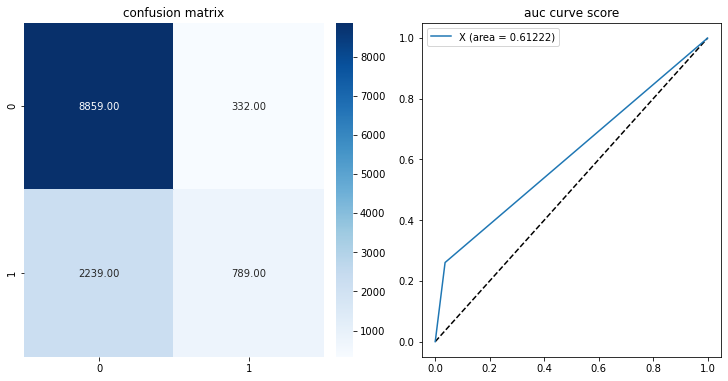

In [27]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train_base,y_train_base)
print(model)
predictions_base_model = model.predict(X_test_base)
plot_performance(y_test_base,predictions_base_model,0.5)

### 4.2) Logistic Regression

In [33]:
model = LogisticRegression()
param = {"C":[0.5,1,2], "max_iter": [1000,2000]}
grid_search = GridSearchCV(estimator = model,cv = 2,param_grid = param)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': [0.5, 1, 2], 'max_iter': [1000, 2000]})

LogisticRegression(C=2, max_iter=1000)
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      9191
           1       0.73      0.61      0.66      3028

    accuracy                           0.85     12219
   macro avg       0.81      0.77      0.78     12219
weighted avg       0.84      0.85      0.84     12219



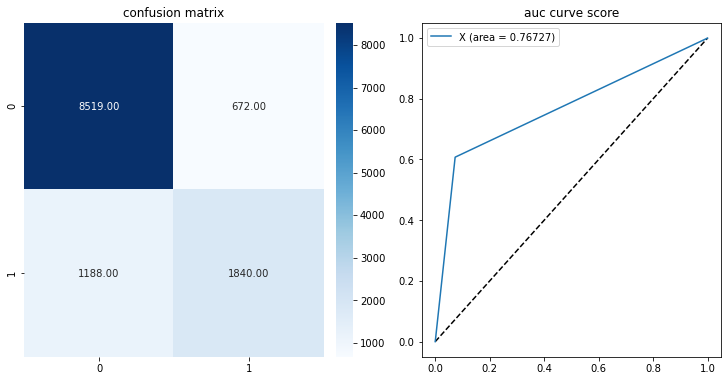

In [34]:
print(grid_search.best_estimator_)
predictions_log_reg_optimized = grid_search.best_estimator_.predict(X_test)
plot_performance(y_test,predictions_log_reg_optimized,0.5)

Simple Feature Selection improves a lot performances!!

## 4.3) RandomForestClassifier

In [35]:
print(grid_search.best_estimator_)
tree = RandomForestClassifier(n_jobs = -1)
param = {"n_estimators":[300,500,1000], "criterion": ["gini","entropy"], "class_weight": [None,"balanced"]}
grid_search = GridSearchCV(estimator = tree,cv = 2,param_grid = param)
grid_search.fit(X_train,y_train)

LogisticRegression(C=2, max_iter=1000)


GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'n_estimators': [300, 500, 1000]})

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      9191
           1       0.73      0.62      0.68      3028

    accuracy                           0.85     12219
   macro avg       0.81      0.78      0.79     12219
weighted avg       0.85      0.85      0.85     12219



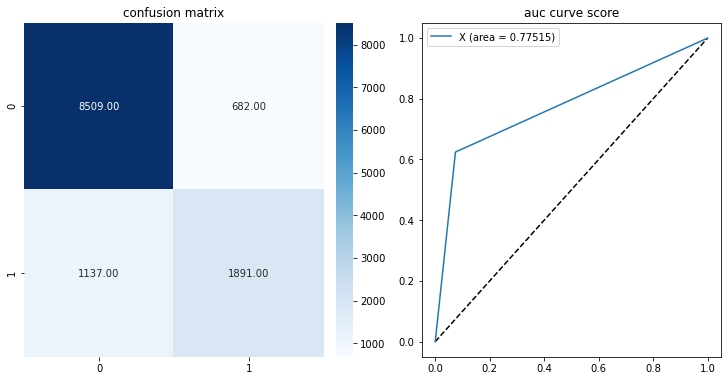

In [36]:
print(grid_search.best_estimator_.get_params())
predictions_rf = grid_search.best_estimator_.predict(X_test)
plot_performance(y_test,predictions_rf,0.5)

## 4.4) LGBM Classifier

In [47]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter

ist_dic = Counter(y_train)
pos_weight = ist_dic[0]/ist_dic[1]
lgb = LGBMClassifier(n_jobs = 1)
param = {"n_estimators":[300,500,1000],"scale_pos_weight" : [None,1,2,3]}
grid_search = GridSearchCV(estimator = lgb,cv = 2,param_grid = param)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=LGBMClassifier(n_jobs=1),
             param_grid={'n_estimators': [300, 500, 1000],
                         'scale_pos_weight': [None, 1, 2, 3]})

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      9191
           1       0.73      0.62      0.68      3028

    accuracy                           0.85     12219
   macro avg       0.81      0.78      0.79     12219
weighted avg       0.85      0.85      0.85     12219



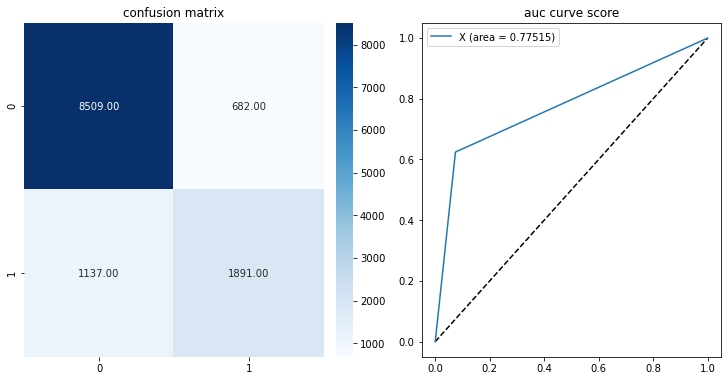

In [46]:
print(grid_search.best_estimator_.get_params())
predictions_lgb = grid_search.best_estimator_.predict(X_test)
plot_performance(y_test,predictions_lgb,0.5)

## 5) Stacking Classifier

In [49]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

estimators = [
             ("lr", LogisticRegression(max_iter = 1000)),
             ("dt",RandomForestClassifier(n_jobs = -1, n_estimators = 1000)),
             ("lgb", LGBMClassifier(n_jobs = 1))
             ]

clf = StackingClassifier(estimators=estimators,
                         final_estimator= XGBClassifier(n_jobs = 1,
                                                        scale_pos_weight = 3,
                                                        tree_method = "hist")
                        )

clf.fit(X_train, y_train).score(X_test, y_test)

C:\Users\giord\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\giord\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:34:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8300188231442835

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      9191
           1       0.62      0.84      0.71      3028

    accuracy                           0.83     12219
   macro avg       0.78      0.83      0.79     12219
weighted avg       0.86      0.83      0.84     12219



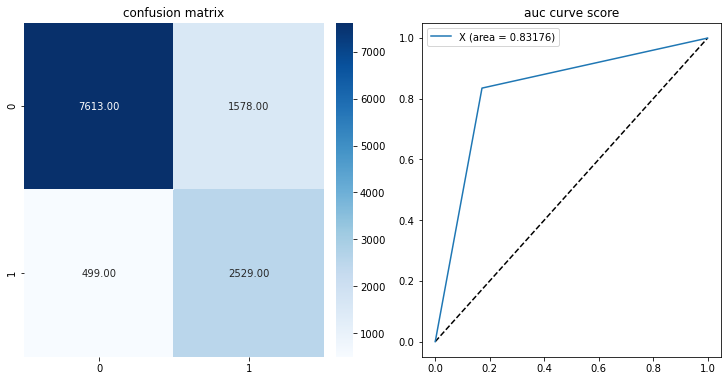

In [50]:
#print(clf)
predictions_stacked =clf.predict(X_test)
plot_performance(y_test,predictions_stacked,0.5)

## Comparing models

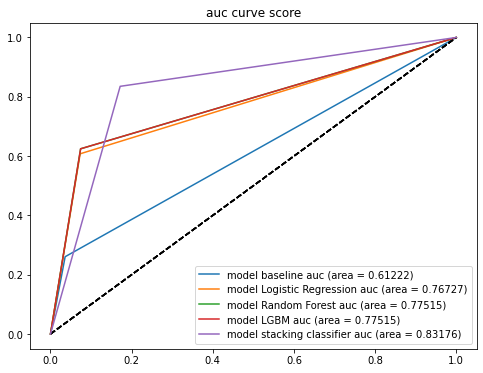

In [53]:
plt.figure(figsize = (8,6))
model_dict = {"baseline":{"pred" : predictions_base_model},
              "Logistic Regression": {"pred":predictions_log_reg_optimized},
              "Random Forest": {"pred" : predictions_rf},
              "LGBM": {"pred": predictions_lgb},
              "stacking classifier": {"pred": predictions_stacked}}
model_dict = plot_multiple_roc_curve(y_test, model_dict, 0.5)

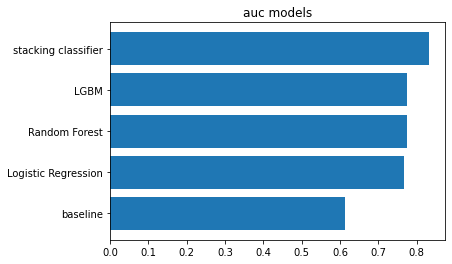

In [54]:
model_dict_auc = dict(sorted({k:v["auc"] for k,v in model_dict.items()}.items(), key = lambda x: x[1]))
plt.barh(list(model_dict_auc.keys()),list(model_dict_auc.values()))
plt.title("auc models")
plt.show()

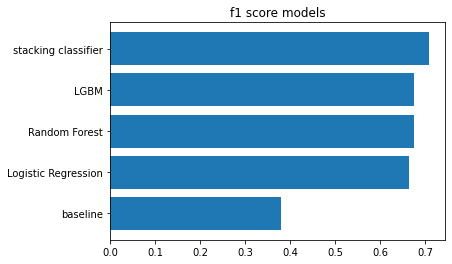

In [55]:
model_dict_f1_score = dict(sorted({k:v["f1_score"] for k,v in model_dict.items()}.items(), key = lambda x: x[1]))
plt.barh(list(model_dict_f1_score.keys()),list(model_dict_f1_score.values()))
plt.title("f1 score models")
plt.show()

### The stacking Classifier seems to overcome all the single models